In [3]:
# Package imports

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# ML related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Functions related to creation and plotting

def mandelbrot(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = z * z + c
        if abs(z) > 2:
            return i
    return max_iter

def plot_mandelbrot(x_min, x_max, y_min, y_max, width, height, max_iter):
    img = np.zeros((width, height))
    for x in tqdm(range(width)):
        for y in range(height):
            real = x_min + (x_max - x_min) * x / width
            imag = y_min + (y_max - y_min) * y / height
            c = complex(real, imag)
            img[x, y] = mandelbrot(c, max_iter)
    plt.figure(dpi=2000)
    plt.imshow(img.T, origin='lower', extent=(x_min, x_max, y_min, y_max), cmap='hot')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.title('Mandelbrot Set')
    plt.show()

    return img

In [ ]:
# Creating the plot

# Set the parameters for the plot
x_min, x_max = -2, 0.5
y_min, y_max = -1, 1
width, height = 20000, 20000 #These can be taken also as measures of resolution
max_iter = 10

# Generate and plot the Mandelbrot set
img = plot_mandelbrot(x_min, x_max, y_min, y_max, width, height, max_iter)

In [57]:
# Defining the neural network, and other similar function for training

# Set the random seed for reproducibility. Should do for later work
#torch.manual_seed(42)
#np.random.seed(42)

# Generate boundary points on the Mandelbrot set
def generate_boundary_points(num_points, width, height, max_iter):
    #percentage = 0.9
    img = np.zeros((width, height))
    boundary_points = []
    for x in range(width):
        for y in range(height):
            real = x_min + (x_max - x_min) * x / width
            imag = y_min + (y_max - y_min) * y / height
            c = complex(real, imag)
            escape_time = mandelbrot(c, max_iter)
            if escape_time == max_iter - 1:
                boundary_points.append([real, imag])
    boundary_points = np.array(boundary_points)
    #num_points = int(percentage * len(boundary_points))
    indices = np.random.choice(len(boundary_points), num_points, replace=True) #the change to True was made recently. Alternatively change sample size?
    return boundary_points[indices]

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define a similar NN with batch normalisation included
class NeuralNetworkBN(nn.Module):
    def __init__(self):
        super(NeuralNetworkBN, self).__init__()
        self.fc1 = nn.Linear(2, 16)

# Define the training function
def train_model(model, data, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in tqdm(range(num_epochs)):
        model.train()
        inputs = torch.Tensor(data)
        targets = torch.Tensor(data)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [54]:
# Parameters for training and model creation

num_epochs = 2000
learning_rate = 0.001
num_points = 10000
num_pred = 10000

width = 800
height = 800
max_iter = 100

In [ ]:
# Creating and plotting a neural network. Note that at the moment loss is not well recorded

# Generate boundary points on the Mandelbrot set
boundary_points = generate_boundary_points(num_points, width, height, max_iter)

# Create the neural network model
model = NeuralNetwork()

# Train the model
train_model(model, boundary_points, num_epochs, learning_rate)

# Generate points on the boundary for plotting
plot_points = generate_boundary_points(num_points)

# Convert the points to tensors and pass them through the trained model
input_points = torch.Tensor(plot_points)
predicted_points = model(input_points).detach().numpy()

# Plot the predicted points and the original boundary points
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='blue', label='Original Boundary')
plt.scatter(predicted_points[:, 0], predicted_points[:, 1], color='red', label='Predicted Boundary')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting the Boundary of the Mandelbrot Set')
plt.legend()
plt.show()

# Testing methods of generating boundary points. The current method is inadequate

In [ ]:
num_points = 100  # Number of points to generate
boundary_points = mandelbrot_boundary(num_points)

#for point in boundary_points:
#    print(point)

def plot_mandelbrot_boundary(points):
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]

    plt.scatter(x_values, y_values, s=5, c='black')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Boundary Points of Mandelbrot Set')
    plt.grid(True)
    plt.show()

# Plot the boundary points
plot_mandelbrot_boundary(boundary_points)

In [6]:
# Calculating the boundary

def mandelbrot(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = z * z + c
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_boundary_2(num_points, max_iter, step_size):
    #Variables
    # num_points = the number of points on the boundary you want returned. They will be evenly distributed
    # max_iter = the number of iterations considered. Used to calcualte whether a point is in the set or not
    # step_size = the distance between points considered. A smaller step size results in a more accurate selection

    
    # Initialising the list which will be used soon
    points = np.zeros(num_points, dtype='complex')
    
    for i in tqdm(range(num_points)):
        angle = 2 * np.pi * i / num_points # setting the angles evenly distributed
        cx = 0.0 # Initialising the constant terms to zero
        cy = 0.0
        c = complex(cx, cy)
        z = complex(cx, cy)
        #print(angle)

        while abs(c) < 2: # terminate when the range of the set is definitely exited
            if mandelbrot(c, max_iter) == max_iter: #if the point is inside the set
                cx += step_size * np.cos(angle)
                cy += step_size * np.sin(angle)
                c = complex(cx, cy)
            else:
                points[i] = c
                #print(c)
                break
            
    return points

In [35]:
num_points = 100000
max_iter = 100
step_size = 0.01

points = mandelbrot_boundary_2(num_points, max_iter, step_size)
print(len(points))
#print(points)

100%|██████████| 100000/100000 [02:39<00:00, 626.28it/s]

100000


In [8]:
# Define the plot_complex function. This cell is actually useful

def plot_complex(points):
    # takes a list of complex values and plots them on a 2D plane
    length = len(points)
    x_values = np.zeros(length)
    y_values = np.zeros(length)

    for i in range(length):
        x_values[i] = points[i].real
        y_values[i] = points[i].imag

    plt.scatter(x_values, y_values, s=1, c='black')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Boundary Points of Mandelbrot Set')
    plt.grid(True)
    plt.show()

# Plot the boundary points
#plot_complex(points)

In [ ]:
# Creating and training a neural network using these new boundary points calculations. We'll see.

# Generate boundary points on the Mandelbrot set
#boundary_points = generate_boundary_points(num_points, width, height, max_iter)
boundary_points = points
# Create the neural network model
model = NeuralNetwork()

# Train the model
train_model(model, boundary_points, num_epochs, learning_rate)

# Generate points on the boundary for plotting
plot_points = generate_boundary_points(num_points)

# Convert the points to tensors and pass them through the trained model
input_points = torch.Tensor(plot_points)
predicted_points = model(input_points).detach().numpy()

# Plot the predicted points and the original boundary points
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='blue', label='Original Boundary')
plt.scatter(predicted_points[:, 0], predicted_points[:, 1], color='red', label='Predicted Boundary')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting the Boundary of the Mandelbrot Set')
plt.legend()
plt.show()

In [9]:
# Uses a greedy algorithm to find the Mandelbrot set boundary. Actually useful

# Calculating the elements within the set
def mandelbrot(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = z * z + c
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_boundary_greedy(max_iter, resolution):
    #Variables
    # max_iter = the number of iterations considered. Used to calcualte whether a point is in the set or not
    # resolution = the size of pixels being considered

    # This is the theoretical range which we need to search over
    x_min, x_max = -2, 0.5
    y_min, y_max = -1, 1

    width_vals = np.arange(x_min, x_max, resolution)
    height_vals = np.arange(y_min, y_max, resolution)
    
    # Initialising the list which will be used soon
    points = []
    
    for x in tqdm(width_vals, position=0, leave=True): # Creates the progress bar. Should probably provide the Verbose attribute
    #for x in width_vals:
        for y in height_vals:
            
            cx = x
            cy = y
            c = complex(cx, cy)

            if mandelbrot(c, max_iter) == max_iter - 1: #if the point is just slightly outside the set
                points.append(c)

    return points

100%|██████████| 2500/2500 [00:41<00:00, 60.87it/s] 


[(-1.5940000000000447+8.881784197001252e-16j), (-1.5610000000000483+8.881784197001252e-16j), (-1.4800000000000573-0.0009999999999991127j), (-1.4800000000000573+0.001000000000000778j), (-1.4020000000000659-0.0019999999999991136j), (-1.4020000000000659+0.00200000000000089j), (-1.3500000000000716-0.06299999999999917j), (-1.3500000000000716+0.06300000000000106j), (-1.337000000000073-0.05299999999999916j), (-1.337000000000073+0.053000000000000824j), (-1.3180000000000751-0.06599999999999917j), (-1.3180000000000751+0.06600000000000095j), (-1.2790000000000794-0.05299999999999916j), (-1.2790000000000794+0.053000000000000824j), (-1.2710000000000803-0.048999999999999155j), (-1.2710000000000803+0.04900000000000082j), (-1.2510000000000825-0.10999999999999921j), (-1.2510000000000825+0.11000000000000099j), (-1.2500000000000826-0.060999999999999166j), (-1.2500000000000826+0.06100000000000083j), (-1.2480000000000828-0.08799999999999919j), (-1.2480000000000828+0.08800000000000097j), (-1.2410000000000836

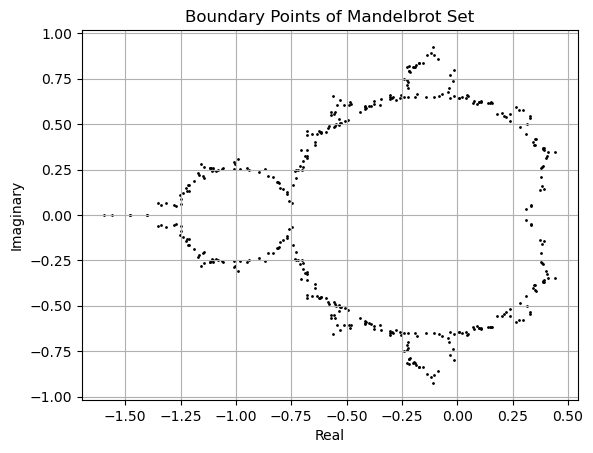

In [10]:
# Example plot

points = mandelbrot_boundary_greedy(100, 0.001)
#print(points)
plot_complex(points)

In [11]:
# Insanely expensive calculation to find the number of boundary points returned for different resolutions

def find_point_num(resolutions, max_iter):
    # resolutions = list of resolutions being tested over
    # max_iter = maximum iterations. The same for all. Could be varied later
    
    num_points = np.zeros(len(resolutions))
    index = 0
    for resolution in tqdm(resolutions):
        points = mandelbrot_boundary_greedy(max_iter, resolution)
        num_points[index] = len(points)
        index += 1

    return num_points

In [ ]:
resolutions = np.arange(0.0001, 0.1, 0.00001)
print(len(resolutions))
max_iter = 100

num_points = find_point_num(resolutions, max_iter)

plt.plot(resolutions, num_points)
plt.xlabel('Resolutions')
plt.ylabel('# boundary points')
plt.title('Number of points found on the boundary using a greedy algorithm')
plt.show()

It might be worth bearing in mind that performing the above calculation with a resolution of 0.0001 (10^(-4)) took 66.7 minutes
The time appears to scale with the square of the different in resolutions.
Therefore, doing the same calculation with a resolution of 10^(-5) would take around 100 times as long. Or around 4 days.
That being said, it would give impecable boundary data
Note that these numbers were calculated for max_iter=100

If I am going to do such a large run, I could at least do a crude coarse graining. That is, remove the obvious regions like the circle centred at 0 with radius 1 and the far out areas which obviously do not contain any boundary. Simply refuse to scan over those regions.

In [ ]:
num_points_copy = num_points

In [ ]:
plt.plot(resolutions, num_points)
plt.xlabel('Resolutions')
plt.ylabel('# boundary points')
plt.title('Number of points found on the boundary using a greedy algorithm')
plt.show()

100%|██████████| 50000/50000 [4:22:12<00:00,  3.18it/s]  


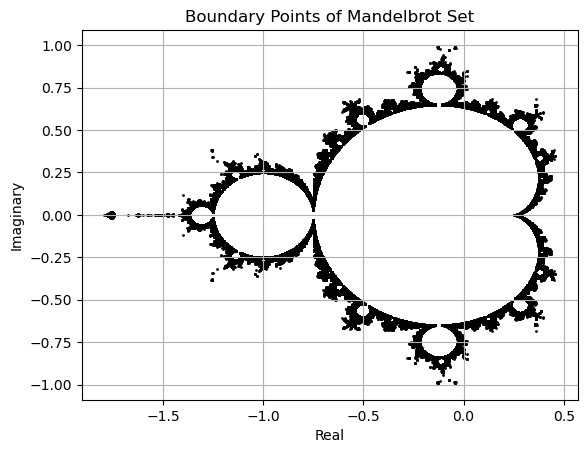

In [12]:
# Actually calculating the boundary, rather than tracking the number of points for different resolutions.

max_iter = 100
resolution = 0.00005 # Very high resolution. I suspect that this calculation will take about 4.5 hours
# Thiss should last this run until I get back in the morning. Written 11/03/2024
# If this works, I should save this boundary in my google drive for later use training neural networks / linear models

points = mandelbrot_boundary_greedy(max_iter, resolution)

plot_complex(points)

In [13]:
import csv

with open('points_file', 'w') as points_file:
    wr = csv.writer(points_file)
    wr.writerow(points)

In [14]:
points_copy = points

In [ ]:
# Here, we create, train, and evaluate a neural network.

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Generate some sample data
def generate_points(num_points, radius):
    points = []
    labels = []
    for _ in range(num_points):
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        points.append([x, y])
        if x**2 + y**2 < radius**2:
            labels.append(1)
        else:
            labels.append(0)
    return np.array(points), np.array(labels)

# Train the neural network
def train(model, data, labels, num_epochs, learning_rate):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(num_epochs)):
        inputs = torch.Tensor(data)
        targets = torch.Tensor(labels).view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10000 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
    return model

# Generate sample data
data, labels = generate_points(1000, 1.0)

# Train the model
model = Net()
num_epochs = 100000
learning_rate = 0.001
trained_model = train(model, data, labels, num_epochs, learning_rate)

# Save the trained model
#torch.save(trained_model.state_dict(), 'model.pth')


In [ ]:
model = trained_model

model.eval()

# Create a grid of points
radius = 2
grid_size = 10000
x_range = np.linspace(-radius, radius, grid_size)
y_range = np.linspace(-radius, radius, grid_size)
X, Y = np.meshgrid(x_range, y_range)
points = np.column_stack((X.ravel(), Y.ravel()))

# Classify the grid points
with torch.no_grad():
    outputs = model(torch.Tensor(points))
    predictions = (outputs > 0.5).float().numpy().reshape(X.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, predictions, cmap='RdBu', alpha=0.5)
plt.scatter(X.ravel(), Y.ravel(), c=predictions.ravel(), cmap='RdBu', s=10)
plt.colorbar()
plt.xlim((-radius, radius))
plt.ylim((-radius, radius))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Decision Boundary')
plt.show()


In [99]:
# Parameters for data generation and model training

# Generate non-boundary points and labels
x_min, x_max = -2, 0.5
y_min, y_max = -1, 1
resolution = 0.001  # Adjust this value as needed

# Training parameters
batch_size = 64
train_ratio = 0.8
num_epochs = 100

# Generating the network 
input_size = 2  # Since each point is a complex number (2 values)
hidden_size = 2 # Hidden size within the network. Somewhat a stand in for parameter number
num_classes = 2  # 0 for non-boundary points, 1 for boundary points
lr = 0.001 # Learning rate

In [100]:
# Preprocess the data

points_tensor = torch.tensor([p.real for p in points] + [p.imag for p in points], dtype=torch.float32)

boundary_points = points_tensor.view(len(points), 2)
#boundary_points = torch.tensor(points, dtype=torch.float32)
boundary_labels = torch.ones(len(boundary_points), dtype=torch.long)

x_vals = torch.arange(x_min, x_max, resolution)
y_vals = torch.arange(y_min, y_max, resolution)
xx, yy = torch.meshgrid(x_vals, y_vals)
print('Successfully made meshgrid')
non_boundary_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)
non_boundary_labels = torch.zeros(len(non_boundary_points), dtype=torch.long)

# Combine boundary and non-boundary points and labels
all_points = torch.cat([boundary_points, non_boundary_points], dim=0)
all_labels = torch.cat([boundary_labels, non_boundary_labels], dim=0)

# Combine data and labels into a TensorDataset
dataset = TensorDataset(all_points, all_labels)

# Shuffle the dataset
shuffled_indices = torch.randperm(len(dataset))
dataset = dataset[shuffled_indices]

# Split the data into training and validation sets
train_size = int(len(dataset) * train_ratio)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

Successfully made meshgrid


In [ ]:
# Attempt 2 at NN creation

# Create the neural network
class MandelbrotClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MandelbrotClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [101]:
# NOT OPERATIONAL: NN creation and training


# Create and train the neural network.
# Includes the final accuracy evaluation

# Create the neural network
class MandelbrotClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MandelbrotClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MandelbrotClassifier(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        inputs = train_data[i:i+batch_size]
        labels = train_labels[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_data)}')

# Evaluate the model on the validation set
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in zip(val_data, val_labels):
        inputs = inputs.unsqueeze(0)  # Add a batch dimension
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        print(f"predicted = ", predicted)
        print(f"labels = ", labels)
        total += 1
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on the validation set: {100 * correct / total}%')

100%|██████████| 100/100 [00:00<00:00, 776.26it/s]

Epoch 10, Training Loss: 0.17369874318440756
Epoch 20, Training Loss: 0.17101303736368814
Epoch 30, Training Loss: 0.16836851835250854
Epoch 40, Training Loss: 0.165767639875412
Epoch 50, Training Loss: 0.16321157415707907
Epoch 60, Training Loss: 0.16070052981376648
Epoch 70, Training Loss: 0.15823420882225037
Epoch 80, Training Loss: 0.15581207474072775
Epoch 90, Training Loss: 0.15343353152275085
Epoch 100, Training Loss: 0.1510978639125824
predicted =  tensor([1])
labels =  tensor(1)
Accuracy on the validation set: 100.0%


In [87]:
# Temporary test cell

print(dataset[1])
print(len(np.where(dataset[1]==0)[0]))

tensor([0, 0, 0,  ..., 0, 0, 0])
5000000


In [89]:
# CAUTION: This function will completely reset the model being used

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            for child_layer in layer.children():
                reset_weights(child_layer)

reset_weights(model)

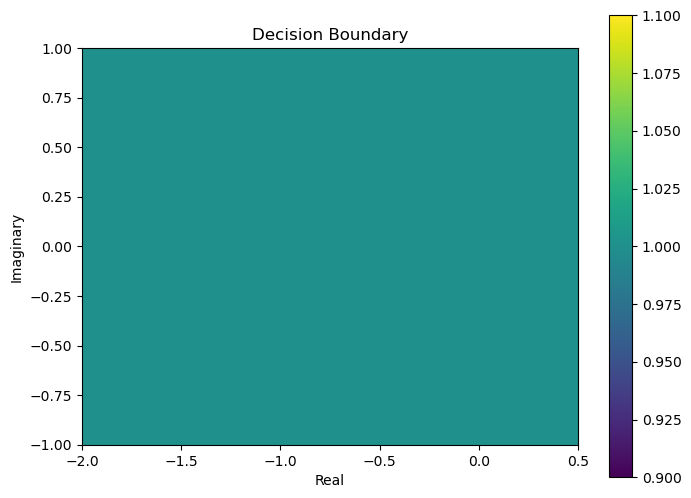

In [93]:
# Generate a grid of points for visualization
x_min, x_max = -2, 0.5
y_min, y_max = -1, 1
resolution = 0.01  # Adjust this value as needed

x_vals = torch.arange(x_min, x_max, resolution)
y_vals = torch.arange(y_min, y_max, resolution)
xx, yy = torch.meshgrid(x_vals, y_vals)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Evaluate the model on the grid points
model.eval()
with torch.no_grad():
    outputs = model(grid_points)
    _, predicted = torch.max(outputs.data, 1)

# Reshape the predictions to match the grid
predicted = predicted.reshape(xx.shape)

# Create a color map
cmap = plt.get_cmap('viridis')

# Plot the decision boundary
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(predicted, cmap=cmap, extent=[x_min, x_max, y_min, y_max])
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.set_title('Decision Boundary')
fig.colorbar(im, ax=ax)
plt.show()

In [131]:
reals = np.zeros(len(dataset[0]))
imags = np.zeros(len(dataset[0]))

for elem in dataset[0]:
    

tensor([-1.3271, -1.3271])


In [132]:
print(len(dataset[0]))

5163045


100%|██████████| 500/500 [00:00<00:00, 61111.17it/s]


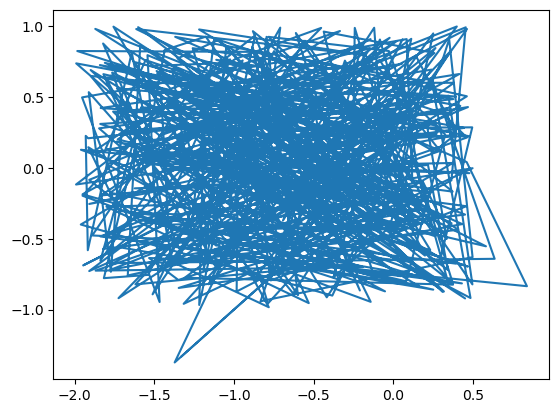

In [142]:
# Producing mini plots of dataset, up to some index
# Clearly, the dataset is fried beyond belief

mini_set = dataset[0][:500]
#print(mini_set)

reals = np.zeros(len(mini_set))
imags = np.zeros(len(mini_set))

for index in tqdm(range(len(mini_set))):
    real, imag = mini_set[index]
    reals[index] = real
    imags[index] = imag

plt.plot(reals, imags)